# 03d DPA MPP surface clusters

compare differences in proportions within MPP subtypes

done with this docker image:

docker run --rm -d --name test_eva -p 8883:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work r_scanpy:vs5

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import scipy.stats as stats

In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)

In [3]:
#Data files
treatments = ['ct', 'indo', 'GCSF', 'dmPGE2', 'pIC']
cell_types = ['HSC', 'MPP1', 'MPP', 'MPP2',  'MPP3/4']
cell_type_names = ['HSC', 'MPP1', 'MPP', 'MPP2',  'MPP3']

for i in range(len(cell_types)):
    cell = cell_types[i]
    cell_name = cell_type_names[i]
    results_df = []
    results_df = pd.DataFrame()
    
    for treatment in treatments:

        path_name = './write/' + 'MPP_MPPsurf_within_leiden_' + treatment + '.csv'
        df = pd.read_csv(path_name)
        
        df = df.set_index('Unnamed: 0')
        
        row = pd.DataFrame(df.loc[cell,:]).T
        row.index = [treatment]
        
        results_df = results_df.append(row)
    
    
    save_name = './write/' + 'clusters_by_surf_' + cell_name +'.csv'
    results_df.to_csv(save_name)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Do DPA for subgroups

In [4]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [5]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [6]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(ggplot2)
library(plyr)

source("diffprop_functions.R");

## Comparison MPP clusters - MPPs

In [7]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/clusters_by_surf_MPP.csv', index_col = 0)
MPP = MPP.fillna(0)
MPP[MPP < 5] = 0
MPP

,Acute-Activation,Cell-cycle,Interferon,Interferon cell-cycle,Metabolism,Myeloid,Primed,Progenitor
ct,7.0,18.0,0.0,0.0,25.0,0.0,30.0,157.0
indo,5.0,18.0,0.0,0.0,35.0,0.0,77.0,265.0
GCSF,8.0,31.0,0.0,0.0,47.0,0.0,89.0,257.0
dmPGE2,322.0,46.0,0.0,0.0,31.0,0.0,0.0,49.0
pIC,0.0,16.0,222.0,13.0,19.0,0.0,79.0,131.0


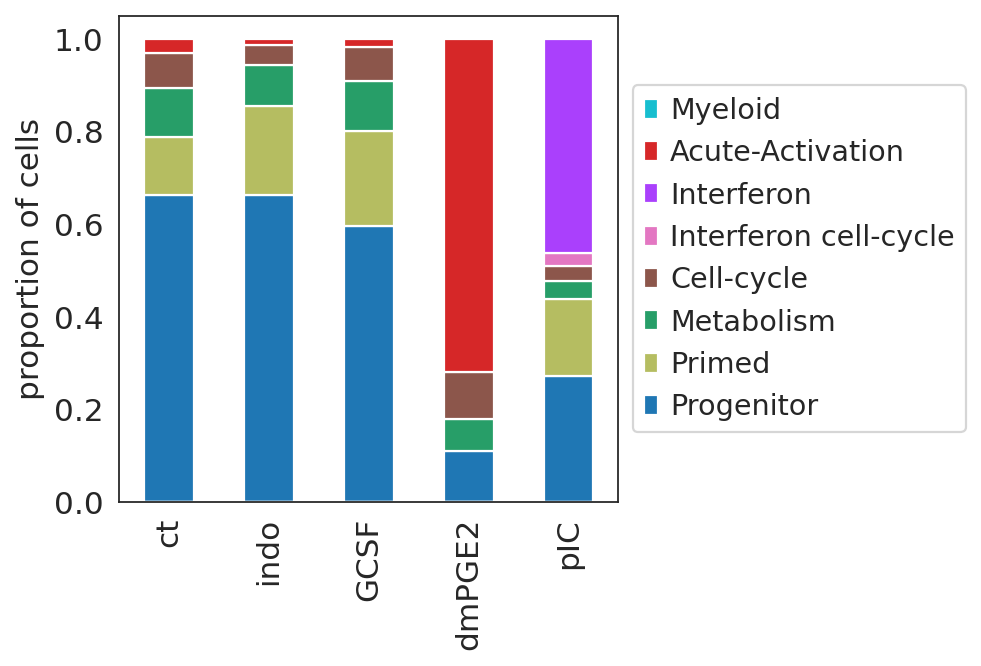

In [8]:
sns.set_style("white")

def_color = ['#1f77b4','#b5bd61', '#279e68', '#8c564b', 
                               '#e377c2', '#aa40fc', '#d62728', 'tab:cyan']

percent_abs_v = MPP.T.iloc[:,0:8].div(MPP.T.sum(axis=0), axis=1)
percent_abs_v = percent_abs_v.reindex(['Progenitor', 'Primed', 'Metabolism', 'Cell-cycle', 
                                       'Interferon cell-cycle', 'Interferon', 'Acute-Activation','Myeloid'])

ax = percent_abs_v.T.plot.bar(stacked=True, color = def_color, figsize=(4, 4))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("proportion of cells")
#plt.grid(b=None) # turns off gridlines
plt.savefig('./figures/MPP_onlyMPP_leiden_within_treatment.pdf', bbox_inches = "tight")

In [9]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       Acute.Activation Cell.cycle Interferon Interferon.cell.cycle Metabolism
ct                    7         18          0                     0         25
indo                  5         18          0                     0         35
GCSF                  8         31          0                     0         47
dmPGE2              322         46          0                     0         31
pIC                   0         16        222                    13         19
       Myeloid Primed Progenitor
ct           0     30        157
indo         0     77        265
GCSF         0     89        257
dmPGE2       0      0         49
pIC          0     79        131


In [10]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

obs.counts/apply(obs.counts, 1, sum)

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [11]:
%%R
### P-value tests for old vs new
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))
print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))

[1] "indo"
     Acute.Activation            Cell.cycle            Interferon 
              0.44227               0.33657               0.49945 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.14245               0.41373                   NaN 
               Primed            Progenitor 
              0.28984               0.49820 
[1] "GCSF"
     Acute.Activation            Cell.cycle            Interferon 
              0.45774               0.46421               0.48047 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.14177               0.46605                   NaN 
               Primed            Progenitor 
              0.25057               0.35493 
[1] "dmPGE2"
     Acute.Activation            Cell.cycle            Interferon 
              0.00000               0.35581               0.46062 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.14148               0.34019     

## Comparison MPP clusters - MPP1s

In [12]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/clusters_by_surf_MPP1.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP[MPP < 5] = 0

MPP

,Acute-Activation,Cell-cycle,Interferon,Interferon cell-cycle,Metabolism,Myeloid,Primed,Progenitor
ct,1.0,8.0,0.0,0.0,15.0,0.0,3.0,50.0
indo,0.0,14.0,1.0,0.0,18.0,0.0,4.0,84.0
GCSF,0.0,11.0,0.0,0.0,32.0,0.0,6.0,106.0
dmPGE2,94.0,26.0,0.0,0.0,34.0,0.0,1.0,70.0
pIC,0.0,19.0,72.0,12.0,14.0,0.0,10.0,73.0


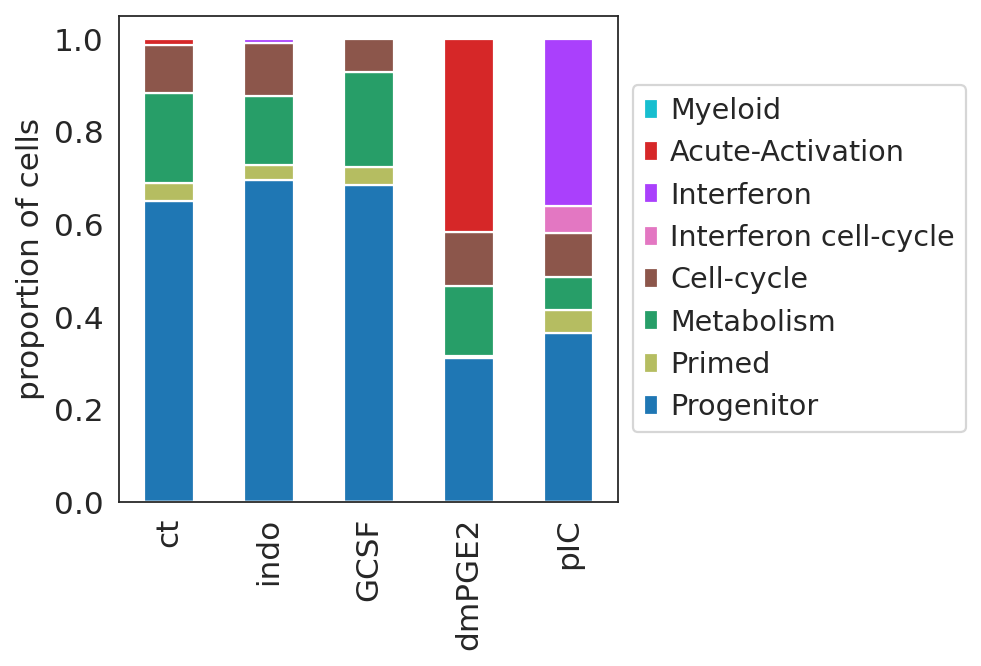

In [13]:
sns.set_style("white")

def_color = ['#1f77b4','#b5bd61', '#279e68', '#8c564b', 
                               '#e377c2', '#aa40fc', '#d62728', 'tab:cyan']

percent_abs_v = MPP.T.iloc[:,0:8].div(MPP.T.sum(axis=0), axis=1)
percent_abs_v = percent_abs_v.reindex(['Progenitor', 'Primed', 'Metabolism', 'Cell-cycle', 
                                       'Interferon cell-cycle', 'Interferon', 'Acute-Activation','Myeloid'])

ax = percent_abs_v.T.plot.bar(stacked=True, color = def_color, figsize=(4, 4))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("proportion of cells")
#plt.grid(b=None) # turns off gridlines
plt.savefig('./figures/MPP_onlyMPP1_leiden_within_treatment.pdf', bbox_inches = "tight")

In [14]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       Acute.Activation Cell.cycle Interferon Interferon.cell.cycle Metabolism
ct                    1          8          0                     0         15
indo                  0         14          1                     0         18
GCSF                  0         11          0                     0         32
dmPGE2               94         26          0                     0         34
pIC                   0         19         72                    12         14
       Myeloid Primed Progenitor
ct           0      3         50
indo         0      4         84
GCSF         0      6        106
dmPGE2       0      1         70
pIC          0     10         73


In [15]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

obs.counts/apply(obs.counts, 1, sum)

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [16]:
%%R
### P-value tests for old vs new
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))
print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))

[1] "indo"
     Acute.Activation            Cell.cycle            Interferon 
              0.41295               0.42275               0.42211 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.11245               0.38822                   NaN 
               Primed            Progenitor 
              0.31239               0.43962 
[1] "GCSF"
     Acute.Activation            Cell.cycle            Interferon 
              0.46652               0.38333               0.44124 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.11354               0.47270                   NaN 
               Primed            Progenitor 
              0.35934               0.47331 
[1] "dmPGE2"
     Acute.Activation            Cell.cycle            Interferon 
              0.00482               0.43294               0.38984 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.11337               0.39884     

## Comparison MPP clusters - MPP2s

In [17]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/clusters_by_surf_MPP2.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP[MPP < 5] = 0

MPP

,Acute-Activation,Cell-cycle,Interferon,Interferon cell-cycle,Metabolism,Myeloid,Primed,Progenitor
ct,0.0,8.0,0.0,0.0,10.0,1.0,4.0,5.0
indo,0.0,11.0,0.0,0.0,21.0,1.0,4.0,3.0
GCSF,0.0,19.0,0.0,0.0,26.0,1.0,5.0,7.0
dmPGE2,22.0,13.0,0.0,0.0,24.0,11.0,0.0,2.0
pIC,0.0,10.0,19.0,7.0,19.0,7.0,6.0,10.0


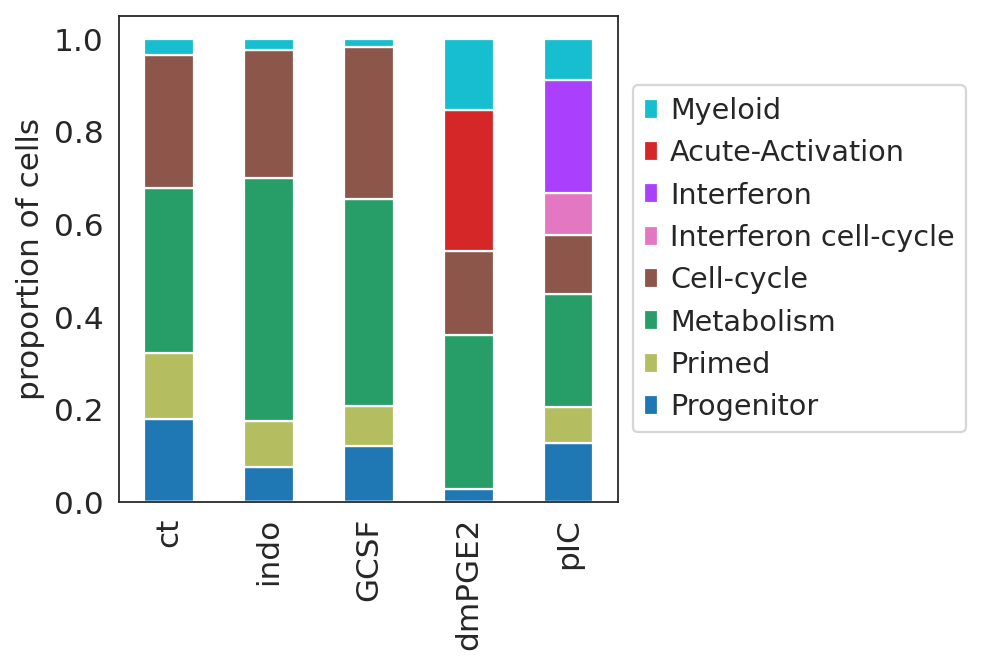

In [18]:
sns.set_style("white")

def_color = ['#1f77b4','#b5bd61', '#279e68', '#8c564b', 
                               '#e377c2', '#aa40fc', '#d62728', 'tab:cyan']

percent_abs_v = MPP.T.iloc[:,0:8].div(MPP.T.sum(axis=0), axis=1)
percent_abs_v = percent_abs_v.reindex(['Progenitor', 'Primed', 'Metabolism', 'Cell-cycle', 
                                       'Interferon cell-cycle', 'Interferon', 'Acute-Activation','Myeloid'])

ax = percent_abs_v.T.plot.bar(stacked=True, color = def_color, figsize=(4, 4))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("proportion of cells")
#plt.grid(b=None) # turns off gridlines
plt.savefig('./figures/MPP_onlyMPP2_leiden_within_treatment.pdf', bbox_inches = "tight")

In [19]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       Acute.Activation Cell.cycle Interferon Interferon.cell.cycle Metabolism
ct                    0          8          0                     0         10
indo                  0         11          0                     0         21
GCSF                  0         19          0                     0         26
dmPGE2               22         13          0                     0         24
pIC                   0         10         19                     7         19
       Myeloid Primed Progenitor
ct           1      4          5
indo         1      4          3
GCSF         1      5          7
dmPGE2      11      0          2
pIC          7      6         10


In [20]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

obs.counts/apply(obs.counts, 1, sum)

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [21]:
%%R
### P-value tests for old vs new
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))
print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))

[1] "indo"
     Acute.Activation            Cell.cycle            Interferon 
              0.19961               0.41163               0.17410 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.06916               0.32360               0.22138 
               Primed            Progenitor 
              0.27695               0.23484 
[1] "GCSF"
     Acute.Activation            Cell.cycle            Interferon 
              0.20456               0.41813               0.17779 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.06932               0.38631               0.21735 
               Primed            Progenitor 
              0.28692               0.32627 
[1] "dmPGE2"
     Acute.Activation            Cell.cycle            Interferon 
              0.04610               0.33822               0.17701 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.06928               0.43420     

## Comparison MPP clusters - MPP3/4s

In [22]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/clusters_by_surf_MPP3.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP[MPP < 5] = 0

MPP

,Acute-Activation,Cell-cycle,Interferon,Interferon cell-cycle,Metabolism,Myeloid,Primed,Progenitor
ct,0.0,113.0,2.0,0.0,173.0,1.0,209.0,9.0
indo,0.0,193.0,8.0,1.0,311.0,3.0,374.0,11.0
GCSF,2.0,190.0,4.0,1.0,353.0,7.0,449.0,20.0
dmPGE2,635.0,288.0,1.0,0.0,244.0,29.0,27.0,5.0
pIC,0.0,166.0,387.0,164.0,263.0,13.0,344.0,8.0


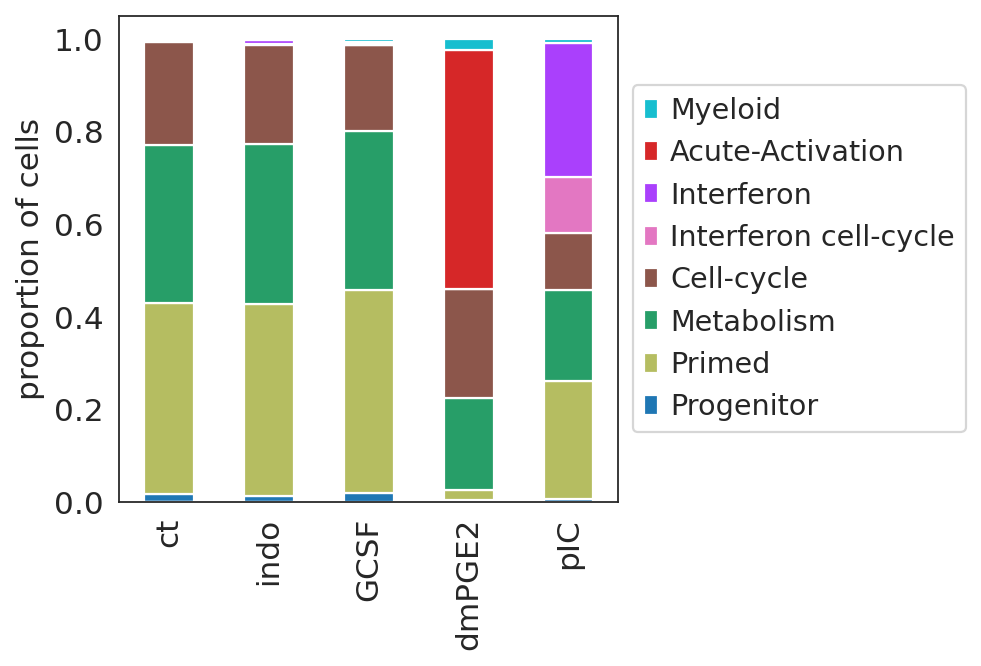

In [23]:
sns.set_style("white")

def_color = ['#1f77b4','#b5bd61', '#279e68', '#8c564b', 
                               '#e377c2', '#aa40fc', '#d62728', 'tab:cyan']

percent_abs_v = MPP.T.iloc[:,0:8].div(MPP.T.sum(axis=0), axis=1)
percent_abs_v = percent_abs_v.reindex(['Progenitor', 'Primed', 'Metabolism', 'Cell-cycle', 
                                       'Interferon cell-cycle', 'Interferon', 'Acute-Activation','Myeloid'])

ax = percent_abs_v.T.plot.bar(stacked=True, color = def_color, figsize=(4, 4))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("proportion of cells")
#plt.grid(b=None) # turns off gridlines
plt.savefig('./figures/MPP_onlyMPP3_leiden_within_treatment.pdf', bbox_inches = "tight")

In [24]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       Acute.Activation Cell.cycle Interferon Interferon.cell.cycle Metabolism
ct                    0        113          2                     0        173
indo                  0        193          8                     1        311
GCSF                  2        190          4                     1        353
dmPGE2              635        288          1                     0        244
pIC                   0        166        387                   164        263
       Myeloid Primed Progenitor
ct           1    209          9
indo         3    374         11
GCSF         7    449         20
dmPGE2      29     27          5
pIC         13    344          8


In [25]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

obs.counts/apply(obs.counts, 1, sum)

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [26]:
%%R
### P-value tests for old vs new
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))
print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))

[1] "indo"
     Acute.Activation            Cell.cycle            Interferon 
              0.48601               0.45973               0.46272 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.47350               0.48095               0.39233 
               Primed            Progenitor 
              0.49050               0.37014 
[1] "GCSF"
     Acute.Activation            Cell.cycle            Interferon 
              0.47631               0.33849               0.48084 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.45213               0.49669               0.31971 
               Primed            Progenitor 
              0.42332               0.45563 
[1] "dmPGE2"
     Acute.Activation            Cell.cycle            Interferon 
              0.00000               0.45018               0.46001 
Interferon.cell.cycle            Metabolism               Myeloid 
              0.45927               0.08391     

## Comparison treatment shift surface MPPs

In [27]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/MPP_MPPsurf_treatment_shift.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP[MPP < 5] = 0

MPP = MPP.T

In [28]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

                      HSC MPP MPP1 MPP2 MPP3.4
dmPGE2                 15 451  225   72   1229
pIC                    37 480  200   78   1345
Acute-Activation        0 342   95   22    637
Interferon             13 226   73   19    402
Interferon cell-cycle   0  13   12    7    166


In [29]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [30]:
%%R
### P-value tests for old vs new
print('Acute-Activation')
print(two.class.test(obs.counts, tip.exp, cond.control="dmPGE2", cond.treatment="Acute-Activation",to.plot=F))
print('Interferon')
print(two.class.test(obs.counts, tip.exp, cond.control="pIC", cond.treatment="Interferon",to.plot=F))
print('Interferon cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="pIC", cond.treatment="Interferon cell-cycle",to.plot=F))
print('Interferon cell-cycle vs Interferon')
print(two.class.test(obs.counts, tip.exp, cond.control="Interferon", cond.treatment="Interferon cell-cycle",to.plot=F))


[1] "Acute-Activation"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.28537 0.11602 0.29030 0.27296 0.32965 
[1] "Interferon"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.47174 0.15512 0.44841 0.36290 0.19084 
[1] "Interferon cell-cycle"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.16258 0.09271 0.35480 0.46305 0.07589 
[1] "Interferon cell-cycle vs Interferon"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.17293 0.03129 0.33463 0.39078 0.03385 


## Comparison surface receptors treatment

In [31]:
# read csvs, rename columns, merge and transpose
# since I didn't know the exact cell numbers assumed 5000 LT-HSCs in control and adjusted everything accordingly,
# total number is the same for all conditions
MPP = pd.read_csv('./raw_data/cell_numbers_dpa.csv', index_col = 0)
MPP = MPP.fillna(0)
MPP = MPP.T
MPP = round(MPP/50)
MPP

,MPP3/4,MPP2,MPP,MPP1,HSC
ct,3198.0,183.0,1390.0,466.0,100.0
indo,3240.0,182.0,1383.0,436.0,96.0
dmPGE2,3177.0,221.0,1240.0,653.0,45.0
pIC,3383.0,228.0,1131.0,499.0,95.0
GCSF,3214.0,218.0,1319.0,482.0,103.0


In [32]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       MPP3.4 MPP2  MPP MPP1 HSC
ct       3198  183 1390  466 100
indo     3240  182 1383  436  96
dmPGE2   3177  221 1240  653  45
pIC      3383  228 1131  499  95
GCSF     3214  218 1319  482 103


In [33]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [34]:
%%R
### P-value tests for old vs new
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))
print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))

[1] "indo"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.41972 0.47094 0.48585 0.39529 0.43965 
[1] "GCSF"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.47222 0.34523 0.36326 0.45565 0.46627 
[1] "dmPGE2"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.45959 0.33250 0.22101 0.07770 0.14387 
[1] "pIC"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.19588 0.30103 0.08704 0.40518 0.47190 


In [35]:
# read csvs, rename columns, merge and transpose
# since I didn't know the exact cell numbers assumed 5000 LT-HSCs in control and adjusted everything accordingly,
# total number is the same for all conditions
MPP = pd.read_csv('./raw_data/cell_numbers_dpa.csv', index_col = 0)
MPP = MPP.fillna(0)
MPP = MPP.T
MPP = round(MPP/5)
MPP

,MPP3/4,MPP2,MPP,MPP1,HSC
ct,31978.0,1830.0,13902.0,4656.0,1000.0
indo,32395.0,1820.0,13830.0,4363.0,957.0
dmPGE2,31771.0,2211.0,12403.0,6525.0,454.0
pIC,33831.0,2283.0,11314.0,4992.0,945.0
GCSF,32137.0,2183.0,13188.0,4824.0,1034.0


In [36]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       MPP3.4 MPP2   MPP MPP1  HSC
ct      31978 1830 13902 4656 1000
indo    32395 1820 13830 4363  957
dmPGE2  31771 2211 12403 6525  454
pIC     33831 2283 11314 4992  945
GCSF    32137 2183 13188 4824 1034


In [37]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [38]:
%%R
### P-value tests for old vs new
print('indo')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="indo",to.plot=F))
print('GCSF')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="GCSF",to.plot=F))
print('dmPGE2')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="dmPGE2",to.plot=F))
print('pIC')
print(two.class.test(obs.counts, tip.exp, cond.control="ct", cond.treatment="pIC",to.plot=F))

[1] "indo"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.27585 0.48074 0.45818 0.23440 0.41343 
[1] "GCSF"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.41014 0.09545 0.12391 0.33785 0.41657 
[1] "dmPGE2"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.38358 0.08238 0.00692 0.00000 0.00089 
[1] "pIC"
 MPP3.4    MPP2     MPP    MPP1     HSC 
0.00366 0.04882 0.00001 0.21029 0.39128 


## Compare treatment within Leiden LT

In [39]:
# read csvs, rename columns, merge and transpose
LT = pd.read_csv('./write/LT_treatment_within_leiden.csv', index_col = 0)
LT = LT.fillna(0)
#LT.insert( 0, 'baseline', 200) # insert baseline column
LT

,Metabolism,Quiescent,Activated,Interferon,Acute-Activation,Cell-cycle
sample,,,,,,
GCSF,1204.0,937.0,780.0,21.0,0.0,42.0
ct,1865.0,1981.0,1556.0,40.0,0.0,79.0
dmPGE2,83.0,24.0,108.0,0.0,261.0,0.0
indo,1757.0,1816.0,1947.0,58.0,1.0,47.0
pIC,188.0,184.0,58.0,316.0,0.0,2.0


In [40]:
div = LT.shape[1]
LT['baseline']= round(LT.sum(axis=1)/div)
LT = LT.T

In [41]:
%%R -i LT
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(LT)
print(obs.counts)

                 GCSF   ct dmPGE2 indo pIC
Metabolism       1204 1865     83 1757 188
Quiescent         937 1981     24 1816 184
Activated         780 1556    108 1947  58
Interferon         21   40      0   58 316
Acute-Activation    0    0    261    1   0
Cell-cycle         42   79      0   47   2
baseline          497  920     79  938 125


In [42]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [43]:
%%R
### P-value tests for old vs new
print('Acute-Activation')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Acute-Activation",to.plot=F))
print('Interferon')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Interferon",to.plot=F))
print('Quiescent')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Quiescent",to.plot=F))
print('Metabolism')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Metabolism",to.plot=F))
print('Activated')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Activated",to.plot=F))
print('Cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Cell-cycle",to.plot=F))

[1] "Acute-Activation"
   GCSF      ct  dmPGE2    indo     pIC 
0.00819 0.00031 0.00000 0.00038 0.13520 
[1] "Interferon"
   GCSF      ct  dmPGE2    indo     pIC 
0.02795 0.00273 0.14495 0.01038 0.00000 
[1] "Quiescent"
   GCSF      ct  dmPGE2    indo     pIC 
0.45733 0.20897 0.06315 0.49431 0.29586 
[1] "Metabolism"
   GCSF      ct  dmPGE2    indo     pIC 
0.15457 0.44856 0.18933 0.32818 0.28732 
[1] "Activated"
   GCSF      ct  dmPGE2    indo     pIC 
0.32750 0.42484 0.35413 0.08817 0.04971 
[1] "Cell-cycle"
   GCSF      ct  dmPGE2    indo     pIC 
0.34967 0.26410 0.26596 0.28524 0.27545 


## Compare treatment within Leiden MPP

In [44]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/MPP_treatment_within_leiden.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP.insert( 0, 'baseline', 200) # insert baseline column
MPP

,Primed,Metabolism,Progenitor,Cell-cycle,Acute-Activation,Interferon,Interferon cell-cycle,Myeloid
sample,,,,,,,,
ct,246.0,223.0,237.0,148.0,8.0,2.0,0.0,2.0
indo,459.0,385.0,388.0,236.0,5.0,13.0,1.0,4.0
GCSF,549.0,458.0,420.0,251.0,10.0,4.0,1.0,9.0
dmPGE2,31.0,334.0,140.0,373.0,1073.0,1.0,0.0,40.0
pIC,439.0,315.0,246.0,211.0,0.0,713.0,196.0,20.0


In [45]:
div = MPP.shape[1]
MPP['baseline']= round(MPP.sum(axis=1)/div)
MPP = MPP.T

In [46]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

                       ct indo GCSF dmPGE2 pIC
Primed                246  459  549     31 439
Metabolism            223  385  458    334 315
Progenitor            237  388  420    140 246
Cell-cycle            148  236  251    373 211
Acute-Activation        8    5   10   1073   0
Interferon              2   13    4      1 713
Interferon cell-cycle   0    1    1      0 196
Myeloid                 2    4    9     40  20
baseline              108  186  213    249 268


In [47]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [48]:
%%R
### P-value tests for old vs new
print('Acute-Activation')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Acute-Activation",to.plot=F))
print('Interferon')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Interferon",to.plot=F))
print('Interferon cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Interferon cell-cycle",to.plot=F))
print('Primed')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Primed",to.plot=F))
print('Metabolism')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Metabolism",to.plot=F))
print('Progenitor')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Progenitor",to.plot=F))
print('Myeloid')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Myeloid",to.plot=F))
print('Cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="baseline", cond.treatment="Cell-cycle",to.plot=F))

[1] "Acute-Activation"
     ct    indo    GCSF  dmPGE2     pIC 
0.02968 0.00313 0.00212 0.00000 0.00025 
[1] "Interferon"
     ct    indo    GCSF  dmPGE2     pIC 
0.03236 0.01155 0.00341 0.00106 0.00000 
[1] "Interferon cell-cycle"
     ct    indo    GCSF  dmPGE2     pIC 
0.08312 0.03922 0.02737 0.01454 0.00000 
[1] "Primed"
     ct    indo    GCSF  dmPGE2     pIC 
0.24828 0.10795 0.06212 0.00051 0.46250 
[1] "Metabolism"
     ct    indo    GCSF  dmPGE2     pIC 
0.32552 0.26406 0.20337 0.25330 0.14852 
[1] "Progenitor"
     ct    indo    GCSF  dmPGE2     pIC 
0.14654 0.10224 0.12378 0.02324 0.11966 
[1] "Myeloid"
     ct    indo    GCSF  dmPGE2     pIC 
0.28059 0.23130 0.32498 0.12620 0.48108 
[1] "Cell-cycle"
     ct    indo    GCSF  dmPGE2     pIC 
0.38746 0.43056 0.48631 0.21797 0.13226 


## Compare myeloid proportion within Surface of all

In [49]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/MPP_leiden_within_MPPsurf_all.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP.insert( 0, 'baseline', 200) # insert baseline column
MPP = MPP.T
MPP

leiden,Primed,Metabolism,Progenitor,Cell-cycle,Acute-Activation,Interferon,Interferon cell-cycle,Myeloid
HSC,0.0,1.0,109.0,1.0,0.0,13.0,0.0,0.0
MPP,278.0,157.0,859.0,129.0,342.0,226.0,13.0,1.0
MPP1,24.0,113.0,383.0,78.0,95.0,73.0,12.0,0.0
MPP2,19.0,100.0,27.0,61.0,22.0,19.0,7.0,21.0
MPP3/4,1403.0,1344.0,53.0,950.0,637.0,402.0,166.0,53.0


In [50]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

       Primed Metabolism Progenitor Cell.cycle Acute.Activation Interferon
HSC         0          1        109          1                0         13
MPP       278        157        859        129              342        226
MPP1       24        113        383         78               95         73
MPP2       19        100         27         61               22         19
MPP3/4   1403       1344         53        950              637        402
       Interferon.cell.cycle Myeloid
HSC                        0       0
MPP                       13       1
MPP1                      12       0
MPP2                       7      21
MPP3/4                   166      53


In [51]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [52]:
%%R
### P-value test MPP2 vs rest
print('HSC')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP2", cond.treatment="HSC",to.plot=F))
print('MPP')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP2", cond.treatment="MPP",to.plot=F))
print('MPP1')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP2", cond.treatment="MPP1",to.plot=F))
print('MPP3/4')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP2", cond.treatment="MPP3/4",to.plot=F))

[1] "HSC"
               Primed            Metabolism            Progenitor 
              0.33888               0.01269               0.00013 
           Cell.cycle      Acute.Activation            Interferon 
              0.05872               0.25206               0.36628 
Interferon.cell.cycle               Myeloid 
              0.21625               0.02650 
[1] "MPP"
               Primed            Metabolism            Progenitor 
              0.24846               0.01026               0.00041 
           Cell.cycle      Acute.Activation            Interferon 
              0.06899               0.15071               0.28111 
Interferon.cell.cycle               Myeloid 
              0.29043               0.03159 
[1] "MPP1"
               Primed            Metabolism            Progenitor 
              0.36026               0.04891               0.00034 
           Cell.cycle      Acute.Activation            Interferon 
              0.14044               0.33079         

In [53]:
%%R
### P-value test MPP vs rest
print('HSC')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP", cond.treatment="HSC",to.plot=F))
print('MPP2')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP", cond.treatment="MPP2",to.plot=F))
print('MPP1')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP", cond.treatment="MPP1",to.plot=F))
print('MPP3/4')
print(two.class.test(obs.counts, tip.exp, cond.control="MPP", cond.treatment="MPP3/4",to.plot=F))

[1] "HSC"
               Primed            Metabolism            Progenitor 
              0.14435               0.31825               0.02233 
           Cell.cycle      Acute.Activation            Interferon 
              0.33921               0.02463               0.45841 
Interferon.cell.cycle               Myeloid 
              0.28885               0.12072 
[1] "MPP2"
               Primed            Metabolism            Progenitor 
              0.24846               0.01026               0.00041 
           Cell.cycle      Acute.Activation            Interferon 
              0.06899               0.15071               0.28111 
Interferon.cell.cycle               Myeloid 
              0.29043               0.03159 
[1] "MPP1"
               Primed            Metabolism            Progenitor 
              0.04572               0.16946               0.23857 
           Cell.cycle      Acute.Activation            Interferon 
              0.27398               0.21942        

## Compare MPP2 within the myeloid cluster

In [54]:
# read csvs, rename columns, merge and transpose
MPP = pd.read_csv('./write/MPP_MPPsurf_within_leiden_all.csv', index_col = 0)
MPP = MPP.fillna(0)
#MPP.insert( 0, 'baseline', 200) # insert baseline column
MPP = MPP.T
MPP

,HSC,MPP,MPP1,MPP2,MPP3/4
Primed,0.0,278.0,24.0,19.0,1403.0
Metabolism,1.0,157.0,113.0,100.0,1344.0
Progenitor,109.0,859.0,383.0,27.0,53.0
Cell-cycle,1.0,129.0,78.0,61.0,950.0
Acute-Activation,0.0,342.0,95.0,22.0,637.0
Interferon,13.0,226.0,73.0,19.0,402.0
Interferon cell-cycle,0.0,13.0,12.0,7.0,166.0
Myeloid,0.0,1.0,0.0,21.0,53.0


In [55]:
%%R -i MPP
## Read in file of counts of cells in each population across conditions

obs.counts = as.matrix(MPP)
print(obs.counts)

                      HSC MPP MPP1 MPP2 MPP3.4
Primed                  0 278   24   19   1403
Metabolism              1 157  113  100   1344
Progenitor            109 859  383   27     53
Cell-cycle              1 129   78   61    950
Acute-Activation        0 342   95   22    637
Interferon             13 226   73   19    402
Interferon cell-cycle   0  13   12    7    166
Myeloid                 0   1    0   21     53


In [56]:
%%R

## Run an example using error (p) of 0.05 and with 100,000 iterations
tip.exp <- generateNull(obs.counts, n=100000, p=0.1);     # Generate the null distribution based on sampling

print(obs.counts/apply(obs.counts, 1, sum))

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000
[1] 12000
[1] 13000
[1] 14000
[1] 15000
[1] 16000
[1] 17000
[1] 18000
[1] 19000
[1] 20000
[1] 21000
[1] 22000
[1] 23000
[1] 24000
[1] 25000
[1] 26000
[1] 27000
[1] 28000
[1] 29000
[1] 30000
[1] 31000
[1] 32000
[1] 33000
[1] 34000
[1] 35000
[1] 36000
[1] 37000
[1] 38000
[1] 39000
[1] 40000
[1] 41000
[1] 42000
[1] 43000
[1] 44000
[1] 45000
[1] 46000
[1] 47000
[1] 48000
[1] 49000
[1] 50000
[1] 51000
[1] 52000
[1] 53000
[1] 54000
[1] 55000
[1] 56000
[1] 57000
[1] 58000
[1] 59000
[1] 60000
[1] 61000
[1] 62000
[1] 63000
[1] 64000
[1] 65000
[1] 66000
[1] 67000
[1] 68000
[1] 69000
[1] 70000
[1] 71000
[1] 72000
[1] 73000
[1] 74000
[1] 75000
[1] 76000
[1] 77000
[1] 78000
[1] 79000
[1] 80000
[1] 81000
[1] 82000
[1] 83000
[1] 84000
[1] 85000
[1] 86000
[1] 87000
[1] 88000
[1] 89000
[1] 90000
[1] 91000
[1] 92000
[1] 93000
[1] 94000
[1] 95000
[1] 96000
[1] 97000
[1] 98000
[1] 99000
[1] 100000
        

In [57]:
%%R
### P-value tests for old vs new
print('Acute-Activation')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Acute-Activation",to.plot=F))
print('Interferon')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Interferon",to.plot=F))
print('Interferon cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Interferon cell-cycle",to.plot=F))
print('Primed')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Primed",to.plot=F))
print('Metabolism')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Metabolism",to.plot=F))
print('Progenitor')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Progenitor",to.plot=F))
print('Cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="Myeloid", cond.treatment="Cell-cycle",to.plot=F))

[1] "Acute-Activation"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.10672 0.03001 0.26156 0.05042 0.29951 
[1] "Interferon"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.27503 0.03936 0.19764 0.06521 0.25782 
[1] "Interferon cell-cycle"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.10640 0.42482 0.30457 0.07267 0.30685 
[1] "Primed"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.10672 0.21635 0.49422 0.02956 0.31468 
[1] "Metabolism"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.11336 0.39309 0.39894 0.14364 0.35611 
[1] "Progenitor"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00175 0.00000 0.00003 0.04675 0.00317 
[1] "Cell-cycle"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.12092 0.34065 0.38247 0.12257 0.37355 


In [62]:
%%R
### compare Progenitor cluster against everything else
print('Acute-Activation')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Acute-Activation",to.plot=F))
print('Interferon')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Interferon",to.plot=F))
print('Interferon cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Interferon cell-cycle",to.plot=F))
print('Primed')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Primed",to.plot=F))
print('Metabolism')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Metabolism",to.plot=F))
print('Myeloid')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Myeloid",to.plot=F))
print('Cell-cycle')
print(two.class.test(obs.counts, tip.exp, cond.control="Progenitor", cond.treatment="Cell-cycle",to.plot=F))

[1] "Acute-Activation"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00070 0.00038 0.00081 0.46965 0.00000 
[1] "Interferon"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.02335 0.00081 0.00428 0.38457 0.00000 
[1] "Interferon cell-cycle"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00132 0.00000 0.01203 0.34225 0.00000 
[1] "Primed"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00085 0.00000 0.00000 0.37511 0.00000 
[1] "Metabolism"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00077 0.00000 0.00005 0.08128 0.00000 
[1] "Myeloid"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00175 0.00000 0.00003 0.04675 0.00317 
[1] "Cell-cycle"
    HSC     MPP    MPP1    MPP2  MPP3.4 
0.00072 0.00000 0.00004 0.15175 0.00000 


In [59]:
%%R

sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] plyr_1.8.4    ggplot2_3.2.1

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.3       withr_2.1.2      crayon_1.3.4     dplyr_0.8.3     
 [5] assertthat_0.2.1 grid_3.6.1       R6_2.4.0         gtable_0.3.0    
 [9] magrittr_1.5     scales_1.0.0     pillar_1.4.2     rlang_0.4.1     
[13] lazyeval_0.

In [60]:
!pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
anndata2ri             1.0.2              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
bleach                 3.1.0              
blinker                1.4                
certifi                2019.11.28         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
conda                  4.7.12             
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
decorator              4.4.1              
defusedxml             0.6.0              
entrypoints            0.3                
get-version            2.1                
gprofiler-official     1.0.0              
h5py       

In [61]:
sc.logging.print_versions()
pd.show_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.76-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : None
pytest           : 5.3.5
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.